In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

from keras import backend as kb
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import helpers

In [29]:
for index in {'WIG20'}:
# for index in {'WIG20'}:
    for alpha in {0.1}:
        # random seed
        np.random.seed(111)

        # load the data
        path_to_dataset = f'{index}.csv'
        data = pd.read_csv(path_to_dataset, index_col = 'Date')
        data.index = pd.to_datetime(data.index)
        data.sort_values(by = ['Date'], inplace=True, ascending=True)

        #obtaining log returns
        data['log_return'] = np.log(1 + data['Close'].pct_change())
        data = data[1:]

        sequence_length = 20  # here we decide how far back we gonna take a look for prediction
        days_ahead = 1

        # Value at Risk based on realized data with t distribution assumption
        data['VaR'] = 0
        data['VaR'][1:] = helpers.historical_VaR(data['log_return'], 20, alpha)
        data = data[20:]
        print(data.head(5))

        # data['norm_return'] = (data['log_return'] - data['log_return'].mean()) / data['log_return'].std()
        data['norm_return'] = helpers.normalization(data['log_return'])

        x_train, y_train, x_test, y_test = helpers.data_preprocessing(
            returns = data['log_return'],
            value_at_risk = data['log_return'],
            sequence_length = sequence_length,
            days_in_advance = days_ahead,
            split = 0.92
        )


/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


              Close     Open     High      Low Vol. Change %  log_return  \
Date                                                                       
2001-03-26  1388.00  1396.42  1412.92  1388.00    -   -0.08%   -0.000756   
2001-03-27  1377.55  1381.95  1387.79  1358.44    -   -0.75%   -0.007557   
2001-03-28  1390.44  1385.08  1401.55  1384.29    -    0.94%    0.009314   
2001-03-29  1371.31  1372.65  1379.19  1360.31    -   -1.38%   -0.013854   
2001-03-30  1375.89  1371.99  1383.94  1371.99    -    0.33%    0.003334   

                 VaR  
Date                  
2001-03-26 -0.038340  
2001-03-27 -0.038420  
2001-03-28 -0.035831  
2001-03-29 -0.035471  
2001-03-30 -0.032341  


In [61]:
import matplotlib.pyplot as plt

def plot_loss(history, branch):
    training_loss = history[f'{branch}_output_loss']
    val_loss = history[f'val_{branch}_output_loss']
    plt.plot(training_loss, label='Training: loss')
    plt.plot(val_loss, label='Test: loss')
    plt.legend()
    plt.show()

In [56]:
H.history['var_output_loss']

[0.003735041245818138,
 0.0002962280123028904,
 0.0002775744360405952,
 0.00026030384469777346,
 0.0002571924705989659]

[INFO] compiling model...
Epoch 1/5
139/139 [==============================] - 3s 21ms/step - loss: 0.0315 - crisp_output_loss: 0.0190 - var_output_loss: 0.0126 - crisp_output_accuracy: 6.7919e-04 - var_output_accuracy: 6.7919e-04 - val_loss: 0.0035 - val_crisp_output_loss: 0.0031 - val_var_output_loss: 4.0928e-04 - val_crisp_output_accuracy: 0.0000e+00 - val_var_output_accuracy: 0.0000e+00
Epoch 2/5
139/139 [==============================] - 2s 15ms/step - loss: 0.0021 - crisp_output_loss: 0.0016 - var_output_loss: 5.6237e-04 - crisp_output_accuracy: 6.7919e-04 - var_output_accuracy: 6.7919e-04 - val_loss: 0.0031 - val_crisp_output_loss: 0.0029 - val_var_output_loss: 2.5684e-04 - val_crisp_output_accuracy: 0.0000e+00 - val_var_output_accuracy: 0.0000e+00
Epoch 3/5
139/139 [==============================] - 2s 15ms/step - loss: 0.0021 - crisp_output_loss: 0.0014 - var_output_loss: 6.5455e-04 - crisp_output_accuracy: 6.7919e-04 - var_output_accuracy: 6.7919e-04 - val_loss: 7.1701e-04 - 

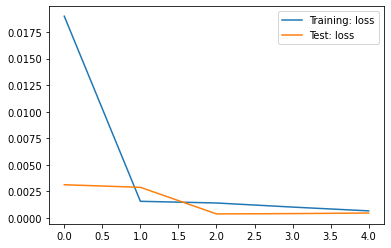

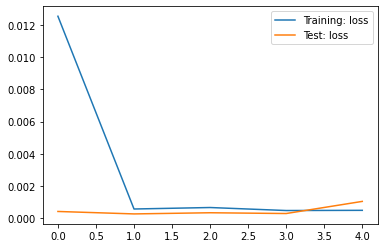

In [179]:
# class jointSupervisionLSTM define with 3 separate nets for lower upper and crisp prediction
class jointSupervisionLSTM:
#     def __init__(self, input_shape = (20,1)):
#         self.input_shape = input_shape

    def build_crisp_return_LSTM(inputs):
        x = LSTM(return_sequences = True, input_shape = (None, 1), units = 50)(inputs)
        x = Dropout(0.2)(x)
        x = LSTM(return_sequences = False, units = 100)(x)
        x = Dropout(0.2)(x)
        x = Dense(units = 10, activation = 'sigmoid')(x)
        x = Dense(units = 1,  activation = 'linear', name = 'crisp_output')(x)
        
        return x

    
    def build_var_return_LSTM(inputs):
        x = LSTM(return_sequences = True, input_shape = (None, 1), units = 50)(inputs)
        x = Dropout(0.2)(x)
        x = LSTM(return_sequences = False, units = 100)(x)
        x = Dropout(0.2)(x)
        x = Dense(units = 10, activation = 'sigmoid')(x)
        x = Dense(units = 1,  activation = 'linear', name = 'var_output')(x)
        
        return x

    @staticmethod
    def build():
        inputs = Input(shape = (20,1))
        crisp_branch = jointSupervisionLSTM.build_crisp_return_LSTM(inputs)
        var_branch = jointSupervisionLSTM.build_var_return_LSTM(inputs)
        model = Model(
            inputs = inputs,
            outputs = [crisp_branch, var_branch],
            name = 'joint_supervision_LSTM'
        )
        
        return model
    
model = jointSupervisionLSTM.build()
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "crisp_output": MSE_custom,
    "var_output": MSE_custom
}
lossWeights = {"crisp_output": 1.0, "var_output": 1.0}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
INIT_LR = 1e-3
EPOCHS = 5
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

H = model.fit(x=x_train,
    y = {"crisp_output": y_train, "var_output": y_train},
    validation_data=(x_test,
        {"crisp_output": y_test, "var_output": y_test}
    ),
    epochs=5, verbose=1)
# save the model to disk
print("[INFO] done")
# model.save(args["model"], save_format="h5")
plot_loss(H.history, 'crisp')
plot_loss(H.history, 'var')

In [182]:
H.

{'verbose': 1, 'epochs': 5, 'steps': 139}

In [177]:
?model.compile

In [178]:
def MSE_custom(y_actual, y_predicted):
#     return kb.sum(kb.square(y_actual - y_predicted))/kb.int_shape(y_actual)[1]
    return kb.mean(kb.square(y_actual[0] - y_predicted[0]))

def MSE_var(y_actual, y_predicted):
    return kb.mean(kb.square(y_actual[0] - y_predicted[0])) + 0.5*kb.mean(kb.relu((y_actual[1] - y_predicted[1]) * -1))

In [ ]:

class FashionNet:
	@staticmethod
	def build_category_branch(inputs, numCategories,
		finalAct="softmax", chanDim=-1):
		# utilize a lambda layer to convert the 3 channel input to a
		# grayscale representation
		x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)
        # (CONV => RELU) * 2 => POOL
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
		# (CONV => RELU) * 2 => POOL
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
        
		# define a branch of output layers for the number of different
		# clothing categories (i.e., shirts, jeans, dresses, etc.)
		x = Flatten()(x)
		x = Dense(256)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numCategories)(x)
		x = Activation(finalAct, name="category_output")(x)
		# return the category prediction sub-network
		return x
    
    @staticmethod
	def build_color_branch(inputs, numColors, finalAct="softmax",
		chanDim=-1):
		# CONV => RELU => POOL
		x = Conv2D(16, (3, 3), padding="same")(inputs)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)
		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
        		# define a branch of output layers for the number of different
		# colors (i.e., red, black, blue, etc.)
		x = Flatten()(x)
		x = Dense(128)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numColors)(x)
		x = Activation(finalAct, name="color_output")(x)
		# return the color prediction sub-network
		return x
    
    @staticmethod
	def build(width, height, numCategories, numColors,
		finalAct="softmax"):
		# initialize the input shape and channel dimension (this code
		# assumes you are using TensorFlow which utilizes channels
		# last ordering)
		inputShape = (height, width, 3)
		chanDim = -1
		# construct both the "category" and "color" sub-networks
		inputs = Input(shape=inputShape)
		categoryBranch = FashionNet.build_category_branch(inputs,
			numCategories, finalAct=finalAct, chanDim=chanDim)
		colorBranch = FashionNet.build_color_branch(inputs,
			numColors, finalAct=finalAct, chanDim=chanDim)
		# create the model using our input (the batch of images) and
		# two separate outputs -- one for the clothing category
		# branch and another for the color branch, respectively
		model = Model(
			inputs=inputs,
			outputs=[categoryBranch, colorBranch],
			name="fashionnet")
		# return the constructed network architecture
		return model

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.fashionnet import FashionNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [ ]:
model = FashionNet.build(96, 96,
	numCategories=len(categoryLB.classes_),
	numColors=len(colorLB.classes_),
	finalAct="softmax")
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"category_output": "categorical_crossentropy",
	"color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

In [ ]:
# train the network to perform multi-output classification
H = model.fit(x=trainX,
	y={"category_output": trainCategoryY, "color_output": trainColorY},
	validation_data=(testX,
		{"category_output": testCategoryY, "color_output": testColorY}),
	epochs=EPOCHS,
	verbose=1)
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")
